김성훈 교수님 딥러닝 강의 11강 따라하기임

1. 간단한 CNN 따라해보기
2. dropout 실습
3. 중간중간 확인 print
4. 인식못한 set을 프린트해보자

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
tf.set_random_seed(777)


In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

learning_rate = 0.001
training_epochs = 15
batch_size = 100


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
keep_prob = tf.placeholder(tf.float32)

X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])

In [4]:
sess = tf.InteractiveSession()

In [5]:
print(X)
print(X_img)
print(Y)

Tensor("Placeholder_1:0", shape=(?, 784), dtype=float32)
Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("Placeholder_2:0", shape=(?, 10), dtype=float32)


In [6]:
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))

L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
print(L1)
L1 = tf.nn.relu(L1)
print(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#If padding == "SAME": output_spatial_shape[i] = ceil(input_spatial_shape[i] / strides[i])
#if padding == "VALID": output_spatial_shape[i] = ceil((input_spatial_shape[i] - (spatial_filter_shape[i]-1) * dilation_rate[i]) / strides[i]).
# ksize 1, 2, 2, 1은 각각 batch_size, 가로, 세로, 채널 이다. batch_size와 채널이 1인 것은 여러 batch, 여러 채널에서 
# max를 땡겨오지 않겠다는 것

print(L1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
print(L1)


Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)


In [7]:
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
print(L2)
L2 = tf.nn.relu(L2)
print(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print(L2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
print(L2)

Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)


In [8]:
# L3 ImgIn shape=(?, 7, 7, 64)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
#    Conv      ->(?, 7, 7, 128)
#    Pool      ->(?, 4, 4, 128)
#    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
print(L3)
L3 = tf.reshape(L3, [-1, 128 * 4 * 4])
print(L3)


Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)


In [9]:
# get_variable()을 쓰려면 노트북에서는 매번 kernel을 새로 시작해줘야 한다 
W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625], initializer=tf.contrib.layers.xavier_initializer())
#W4 = tf.Variable(tf.random_normal([128 * 4* 4, 625], stddev=0.01))
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

In [10]:
# L5 Final FC 625 inputs -> 10 outputs
W5 = tf.get_variable("W5", shape=[625, 10],initializer=tf.contrib.layers.xavier_initializer())
#W5 = tf.Variable(tf.random_normal([625, 10], stddev=0.01))
b5 = tf.Variable(tf.random_normal([10]))
hypothesis = tf.matmul(L4, W5) + b5

In [11]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [12]:
sess.run(tf.global_variables_initializer())

In [13]:
#train
for epoch in range(training_epochs):
    ave_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict =  {X: batch_xs, Y:batch_ys, keep_prob:0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        ave_cost += c / total_batch  # total_batch 만큼 batch가 돌아가면서 반복해 cost를 계산하기에 이걸 total_batch 크기로 
        
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(ave_cost))
print('Learning Finished!')

Epoch: 0001 cost = 0.406660359
Epoch: 0002 cost = 0.094576670
Epoch: 0003 cost = 0.070995473
Epoch: 0004 cost = 0.059974426
Epoch: 0005 cost = 0.050734864
Epoch: 0006 cost = 0.046010858
Epoch: 0007 cost = 0.041467375
Epoch: 0008 cost = 0.038754041
Epoch: 0009 cost = 0.034580565
Epoch: 0010 cost = 0.032515565
Epoch: 0011 cost = 0.030545096
Epoch: 0012 cost = 0.028533454
Epoch: 0013 cost = 0.028148472
Epoch: 0014 cost = 0.026664905
Epoch: 0015 cost = 0.024710917
Learning Finished!


In [14]:
# Test model and check accuracy
Y_pred = tf.argmax(hypothesis, 1)
Y_test = tf.argmax(Y, 1)

correct_prediction = tf.equal(Y_pred, Y_test)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 10000개를 그냥 쓰면 메모리 넘친다. 아래는 5000개씩 둘로 나눠보았다
#print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))
pred_y1, accu_1 = sess.run([Y_pred, accuracy], feed_dict={X: mnist.test.images[0:5000], Y: mnist.test.labels[0:5000], keep_prob: 1})
pred_y2, accu_2 = sess.run([Y_pred, accuracy], feed_dict={X: mnist.test.images[5000:10000], Y: mnist.test.labels[5000:10000], keep_prob: 1})
print(pred_y1.shape, pred_y2.shape)

# 이건 나중에 오류난것 뿌려주기 위해 작업한 것임
pred_y_final = np.append(pred_y1, pred_y2)
test_y_final = np.argmax(mnist.test.labels, 1)
print(pred_y_final.shape, test_y_final.shape)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images[0:5000], Y: mnist.test.labels[0:5000], keep_prob: 1}))

(5000,) (5000,)
(10000,) (10000,)
Accuracy: 0.9906


In [15]:
# 메모리 overflow 대응 Prediction 버전
accu_sum = 0

for i in range(10):
    index = i * 1000
    accu_sum += sess.run(accuracy, feed_dict={X: mnist.test.images[index:index+1000], Y: mnist.test.labels[index:index+1000], keep_prob: 1})
    print(accu_sum)
    
print(accu_sum)
accu_sum = accu_sum / 10
print(accu_sum)

0.990999937057
1.97999995947
2.96899998188
3.96299999952
4.95299994946
5.9509999752
6.94800007343
7.94800019264
8.94300019741
9.93800020218
9.93800020218
0.993800020218


In [16]:
# 예측 틀린걸 image로 보고 싶다

[7 2 1 ..., 4 5 6] [7 2 1 ..., 4 5 6]
62


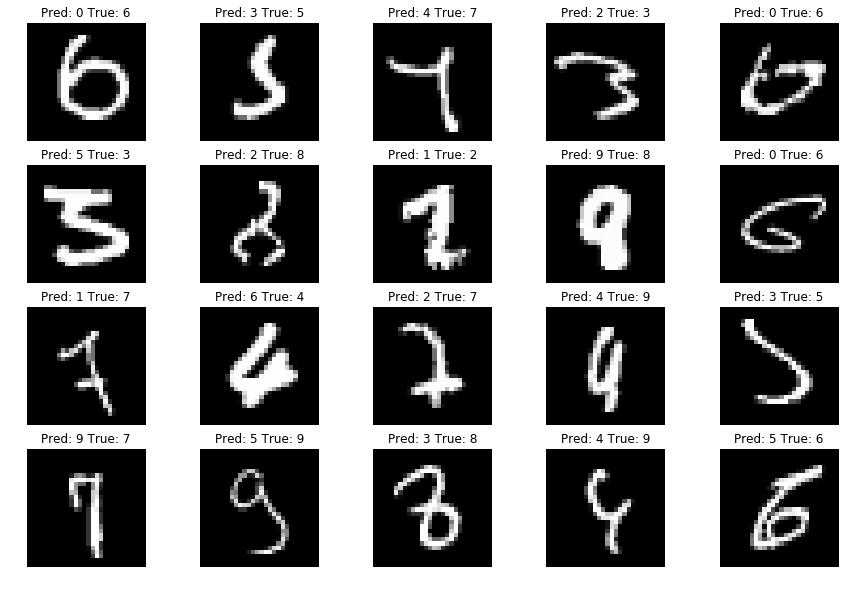

In [27]:
# test set으로 예측한 라벨값과 정답값
print(pred_y_final,test_y_final )

result = (pred_y_final == test_y_final)

wrong_examples = mnist.test.images[result==False]
print(len(wrong_examples))

pred_labels = pred_y_final[result==False]
true_labels = test_y_final[result==False]

def imshow(img, pred_label, true_labels, ax):
    img = img.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    #ax.set_title(f"Pred: {pred_label} True: {true_labels}")  # 파이썬 3.6부터는 이렇게도 된다
    ax.set_title("Pred: {} True: {}".format(pred_label, true_labels))
    ax.axis("off")

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
k = 0

for i in range(4):
    for j in range(5):
        imshow(wrong_examples[k], pred_labels[k], true_labels[k], axes[i, j])
        k += 1
        if (k >= len(wrong_examples)):
            break
    if (k >= len(wrong_examples)):
        break
plt.show()